# Informer Demo

In [ ]:
import sys
if not 'Informer2020' in sys.path:
    sys.path += ['Informer2020']

## Experiments: Train and Test

In [1]:
from utils.tools import dotdict
from exp.exp_informer import Exp_Informer
import torch
import re
import numpy as np
import pandas as pd
import os
import json

In [2]:
args = dotdict()

args.model = 'informer' # model of experiment, options: [informer, informerstack, informerlight(TBD)]

args.data = 'custom' # data
args.root_path = './data/ETT/' # root path of data file


args.data_path = 'processed_holes.csv' # data file
args.features = 'MS' # forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate
args.target = 'XOM' # target feature in S or MS task
args.freq = 't' # freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h
args.checkpoints = './checkpoints' # location of model checkpoints

args.seq_len = 64 # input sequence length of Informer encoder
args.label_len = 60 # start token length of Informer decoder
args.pred_len = 2 # prediction sequence length
# Informer decoder input: concat[start token series(label_len), zero padding series(pred_len)]

args.enc_in = 7 # encoder input size
args.dec_in = 7 # decoder input size
args.c_out = 1 # output size
args.factor = 5 # probsparse attn factor
args.d_model = 512 # dimension of model
args.n_heads = 8 # num of heads
args.e_layers = 2 # num of encoder layers
args.d_layers = 1 # num of decoder layers
args.d_ff = 2048 # dimension of fcn in model
args.dropout = 0.05 # dropout
args.attn = 'prob' # attention used in encoder, options:[prob, full]
args.embed = 'timeF' # time features encoding, options:[timeF, fixed, learned]
args.activation = 'gelu' # activation
args.distil = True # whether to use distilling in encoder
args.output_attention = False # whether to output attention in ecoder
args.mix = True
args.padding = 0

args.batch_size = 32 
args.learning_rate = 0.00001
args.loss = 'mse'
args.lradj = 'type1'
args.use_amp = False # whether to use automatic mixed precision training

args.num_workers = 0
args.itr = 1 # number of runs
args.train_epochs = 10
args.patience = 4
args.des = 'exp'

args.inverse = True # Defaultly False but @Zac thinks it should be True

args.use_gpu = True if torch.cuda.is_available() else False
args.gpu = 0

args.use_multi_gpu = False
args.devices = '0,1'
if args.use_gpu and args.use_multi_gpu:
    args.devices = args.devices.replace(' ','')
    device_ids = args.devices.split(',')
    args.device_ids = [int(id_) for id_ in device_ids]
    args.gpu = args.device_ids[0]

# idk what this is for
args.detail_freq = args.freq
args.freq = args.freq[-1:]

In [3]:
print('Args in experiment:')
print(args)

Args in experiment:
{'model': 'informer', 'data': 'custom', 'root_path': './data/ETT/', 'data_path': 'processed_holes.csv', 'features': 'MS', 'target': 'XOM', 'freq': 't', 'checkpoints': './checkpoints', 'seq_len': 64, 'label_len': 60, 'pred_len': 2, 'enc_in': 7, 'dec_in': 7, 'c_out': 1, 'factor': 5, 'd_model': 512, 'n_heads': 8, 'e_layers': 2, 'd_layers': 1, 'd_ff': 2048, 'dropout': 0.05, 'attn': 'prob', 'embed': 'timeF', 'activation': 'gelu', 'distil': True, 'output_attention': False, 'mix': True, 'padding': 0, 'batch_size': 32, 'learning_rate': 1e-05, 'loss': 'mse', 'lradj': 'type1', 'use_amp': False, 'num_workers': 0, 'itr': 1, 'train_epochs': 10, 'patience': 4, 'des': 'exp', 'inverse': True, 'use_gpu': True, 'gpu': 0, 'use_multi_gpu': False, 'devices': '0,1', 'detail_freq': 't'}


In [4]:
Exp = Exp_Informer

In [5]:
# Args / Settings helper functions

def args_from_setting(setting, args):
    pattern = r"(.+)_(.+)_ft(.+)_sl(.+)_ll(.+)_pl(.+)_ei(.+)_di(.+)_co(.+)_i(.+)_dm(.+)_nh(.+)_el(.+)_dl(.+)_df(.+)_at(.+)_fc(.+)_eb(.+)_dt(.+)_mx(.+)_(.+)_(.+).*"
    match = re.search(pattern, setting)
    if match:
        conv = lambda x: int(x) if x.isdigit() else (False if x=="False" else (True if x=="True" else x))

        (args.model, args.data, args.features, 
        args.seq_len, args.label_len, args.pred_len,
        args.enc_in, args.dec_in, args.c_out, args.inverse,
        args.d_model, args.n_heads, args.e_layers, args.d_layers, args.d_ff, args.attn, args.factor, 
        args.embed, args.distil, args.mix, args.des, ii) = map(conv, match.groups())
        print(args)
    else:
        raise Exception("Issue with setting name")
    
    return args

def setting_from_args(args, ii=0):
    setting = '{}_{}_ft{}_sl{}_ll{}_pl{}_ei{}_di{}_co{}_i{}_dm{}_nh{}_el{}_dl{}_df{}_at{}_fc{}_eb{}_dt{}_mx{}_{}_{}'.format(args.model, args.data, args.features, 
                args.seq_len, args.label_len, args.pred_len,
                args.enc_in, args.dec_in, args.c_out, args.inverse,
                args.d_model, args.n_heads, args.e_layers, args.d_layers, args.d_ff, args.attn, args.factor, 
                args.embed, args.distil, args.mix, args.des, ii)
    
    return setting

### Train & Test *args.itr* models

In [6]:
exp = None
setting = None
for ii in range(args.itr):
    # setting record of experiments
    setting = setting_from_args(args, ii)
    
    # set experiments
    exp = Exp(args)
    
    # train
    print('>>>>>>>start training : {}>>>>>>>>>>>>>>>>>>>>>>>>>>'.format(setting))
    exp.train(setting)
    
    # test
    print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
    exp.test(setting)

    torch.cuda.empty_cache()


Use GPU: cuda:0
>>>>>>>start training : informer_custom_ftMS_sl64_ll60_pl2_ei7_di7_co1_iTrue_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0>>>>>>>>>>>>>>>>>>>>>>>>>>
train 64120
val 9169
test 18337
	iters: 100, epoch: 1 | loss: 2.9069352
	speed: 0.2223s/iter; left time: 4430.2722s
	iters: 200, epoch: 1 | loss: 2.1773152
	speed: 0.2270s/iter; left time: 4500.8623s
	iters: 300, epoch: 1 | loss: 1.5939431
	speed: 0.2278s/iter; left time: 4494.7735s
	iters: 400, epoch: 1 | loss: 1.1884773
	speed: 0.2275s/iter; left time: 4466.4877s
	iters: 500, epoch: 1 | loss: 1.2396290
	speed: 0.2137s/iter; left time: 4174.5439s
	iters: 600, epoch: 1 | loss: 1.2612008
	speed: 0.2240s/iter; left time: 4352.8398s
	iters: 700, epoch: 1 | loss: 0.8745582
	speed: 0.2237s/iter; left time: 4324.9872s
	iters: 800, epoch: 1 | loss: 0.5184524
	speed: 0.2237s/iter; left time: 4302.0989s
	iters: 900, epoch: 1 | loss: 0.5552760
	speed: 0.2241s/iter; left time: 4286.4507s
	iters: 1000, epoch: 1 | loss

## Prediction

In [65]:
# If you already have a trained model, you can set the arguments and model path, then initialize a Experiment and use it to predict
# Prediction is a sequence which is adjacent to the last date of the data, and does not exist in the data
# If you want to get more information about prediction, you can refer to code `exp/exp_informer.py function predict()` and `data/data_loader.py class Dataset_Pred`

# args = dotdict(model='informer', data='WTH', root_path='./data/ETT/', data_path='WTH.csv', features='M', target='WetBulbCelsius', freq='h', checkpoints='./checkpoints/', seq_len=96, label_len=48, pred_len=24, enc_in=12, dec_in=12, c_out=12, d_model=512, n_heads=8, e_layers=2, d_layers=1, s_layers=[3, 2, 1], d_ff=2048, factor=5, padding=0, distil=True, dropout=0.05, attn='prob', embed='timeF', activation='gelu', output_attention=False, do_predict=False, mix=True, cols=None, num_workers=0, itr=2, train_epochs=6, batch_size=32, patience=3, learning_rate=0.0001, des='test', loss='mse', lradj='type1', use_amp=False, inverse=False, use_gpu=True, gpu=0, use_multi_gpu=False, devices='0,1,2,3', detail_freq='h')

manual = False

if manual:
    setting = "informer_custom_ftMS_sl64_ll60_pl2_ei7_di7_co1_iTrue_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0"
    args = args_from_setting(setting, args)

    exp = Exp(args)

path = os.path.join(args.checkpoints, setting, "checkpoint.pth")

exp.predict(setting, True)

pred 1


In [66]:
# the prediction will be saved in ./results/{setting}/real_prediction.npy

prediction = np.load(f"./results/{setting}/real_prediction.npy")

prediction.shape

(1, 2, 1)

### More details about Prediction - prediction function

In [67]:
# here is the detailed code of function predict

def predict(exp, setting, load=False):
    pred_data, pred_loader = exp._get_data(flag='pred')
        
    if load:
        path = os.path.join(exp.args.checkpoints, setting)
        best_model_path = path+'/'+'checkpoint.pth'
        exp.model.load_state_dict(torch.load(best_model_path))

    exp.model.eval()
        
    preds = []
        
    for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(pred_loader):
        batch_x = batch_x.float().to(exp.device)
        batch_y = batch_y.float()
        batch_x_mark = batch_x_mark.float().to(exp.device)
        batch_y_mark = batch_y_mark.float().to(exp.device)

        # decoder input
        if exp.args.padding==0:
            dec_inp = torch.zeros([batch_y.shape[0], exp.args.pred_len, batch_y.shape[-1]]).float()
        elif exp.args.padding==1:
            dec_inp = torch.ones([batch_y.shape[0], exp.args.pred_len, batch_y.shape[-1]]).float()
        else:
            dec_inp = torch.zeros([batch_y.shape[0], exp.args.pred_len, batch_y.shape[-1]]).float()
        dec_inp = torch.cat([batch_y[:,:exp.args.label_len,:], dec_inp], dim=1).float().to(exp.device)
        # encoder - decoder
        if exp.args.use_amp:
            with torch.cuda.amp.autocast():
                if exp.args.output_attention:
                    outputs = exp.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
                else:
                    outputs = exp.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
        else:
            if exp.args.output_attention:
                outputs = exp.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
            else:
                outputs = exp.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
        f_dim = -1 if exp.args.features=='MS' else 0
        batch_y = batch_y[:,-exp.args.pred_len:,f_dim:].to(exp.device)
        
        pred = outputs.detach().cpu().numpy()#.squeeze()
        
        preds.append(pred)

    preds = np.array(preds)
    preds = preds.reshape(-1, preds.shape[-2], preds.shape[-1])
    
    # result save
    folder_path = './results/' + setting +'/'
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    
    np.save(folder_path+'real_prediction.npy', preds)
    
    return preds


In [68]:
# you can also use this prediction function to get result
prediction = predict(exp, setting, True)

pred 1


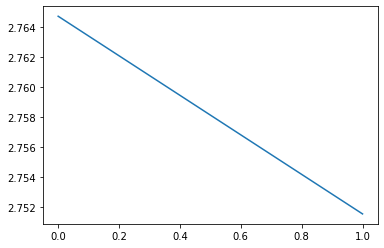

In [69]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(prediction[0,:,-1])
plt.show()

### More details about Prediction - prediction dataset

You can give a `root_path` and `data_path` of the data you want to forecast, and set `seq_len`, `label_len`, `pred_len` and other arguments as other Dataset. The difference is that you can set a more detailed freq such as `15min` or `3h` to generate the timestamp of prediction series.

`Dataset_Pred` only has one sample (including `encoder_input: [1, seq_len, dim]`, `decoder_token: [1, label_len, dim]`, `encoder_input_timestamp: [1, seq_len, date_dim]`, `decoder_input_timstamp: [1, label_len+pred_len, date_dim]`). It will intercept the last sequence of the given data (seq_len data) to forecast the unseen future sequence (pred_len data).

In [70]:
from data.data_loader import Dataset_Pred
from torch.utils.data import DataLoader

In [71]:
Data = Dataset_Pred
timeenc = 0 if args.embed!='timeF' else 1
flag = 'pred'; shuffle_flag = False; drop_last = False; batch_size = 1

freq = args.detail_freq

data_set = Data(
    root_path=args.root_path,
    data_path=args.data_path,
    flag=flag,
    size=[args.seq_len, args.label_len, args.pred_len],
    features=args.features,
    target=args.target,
    timeenc=timeenc,
    freq=freq,

    inverse=args.inverse,
    cols=args.cols
)
data_loader = DataLoader(
    data_set,
    batch_size=batch_size,
    shuffle=shuffle_flag,
    num_workers=args.num_workers,
    drop_last=drop_last)

In [92]:
len(data_set), len(data_loader)

(18337, 18337)

## Visualization

In [74]:
# When we finished exp.train(setting) and exp.test(setting), we will get a trained model and the results of test experiment
# The results of test experiment will be saved in ./results/{setting}/pred.npy (prediction of test dataset) and ./results/{setting}/true.npy (groundtruth of test dataset)

preds = np.load(f"./results/{setting}/pred.npy")
trues = np.load(f"./results/{setting}/true.npy")

# [samples, pred_len, dimensions]
preds.shape, trues.shape

((18336, 2, 1), (18336, 2, 1))

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns

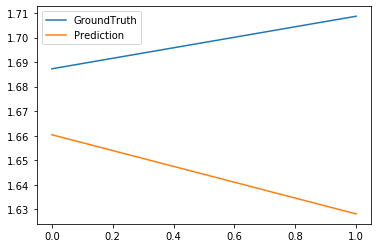

In [76]:
# draw OT prediction
plt.figure()
plt.plot(trues[0,:,-1], label='GroundTruth')
plt.plot(preds[0,:,-1], label='Prediction')
plt.legend()
plt.show()

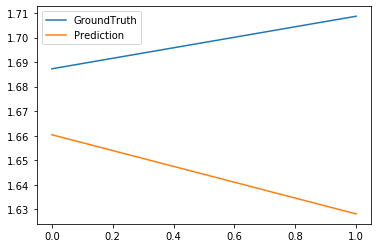

In [77]:
# draw HUFL prediction
plt.figure()
plt.plot(trues[0,:,0], label='GroundTruth')
plt.plot(preds[0,:,0], label='Prediction')
plt.legend()
plt.show()

In [87]:
from data.data_loader import Dataset_Custom
from torch.utils.data import DataLoader

Data = Dataset_Custom
timeenc = 0 if args.embed!='timeF' else 1
flag = 'test'; shuffle_flag = False; drop_last = True; batch_size = 1

data_set = Data(
    root_path=args.root_path,
    data_path=args.data_path,
    flag=flag,
    size=[args.seq_len, args.label_len, args.pred_len],
    features=args.features,
    timeenc=timeenc,
    freq=args.freq,

    target=args.target,
    inverse=args.inverse,
    cols=args.cols
)

data_loader = DataLoader(
    data_set,
    batch_size=batch_size,
    shuffle=shuffle_flag,
    num_workers=args.num_workers,
    drop_last=drop_last)


In [97]:
import os

args.output_attention = True

exp = Exp(args)

model = exp.model

# setting = 'informer_ETTh1_ftM_sl96_ll48_pl24_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0'
path = os.path.join(args.checkpoints,setting,'checkpoint.pth')

print(model.load_state_dict(torch.load(path)))

df = pd.read_csv(os.path.join(args.root_path, args.data_path))
df.head()

Use GPU: cuda:0
<All keys matched successfully>


,date,XOM,CVX,SHEL,COP,BP,PBR,WTI
0,2022-02-01 07:53:00,74.968812,127.016162,50.184981,85.125002,30.163538,9.396644,4.26
1,2022-02-01 07:56:00,74.677859,127.307929,50.184981,85.125002,30.144178,9.396644,4.26
2,2022-02-01 07:57:00,74.774843,127.307929,50.184981,85.125002,30.163538,9.410711,4.26
3,2022-02-01 07:58:00,74.774843,127.405185,50.184981,85.125002,30.173219,9.410711,4.26
4,2022-02-01 07:59:00,74.774843,127.395460,50.184981,85.125002,30.173219,9.410711,4.26


### Attention Visualization

In [98]:
idx = 0
for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(data_loader):
    if i!=idx:
        continue
    batch_x = batch_x.float().to(exp.device)
    batch_y = batch_y.float()

    batch_x_mark = batch_x_mark.float().to(exp.device)
    batch_y_mark = batch_y_mark.float().to(exp.device)
    
    dec_inp = torch.zeros_like(batch_y[:,-args.pred_len:,:]).float()
    dec_inp = torch.cat([batch_y[:,:args.label_len,:], dec_inp], dim=1).float().to(exp.device)
    
    outputs,attn = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)

In [99]:
attn[0].shape, attn[1].shape #, attn[2].shape

(torch.Size([1, 8, 64, 64]), torch.Size([1, 8, 32, 32]))



Showing attention layer 0




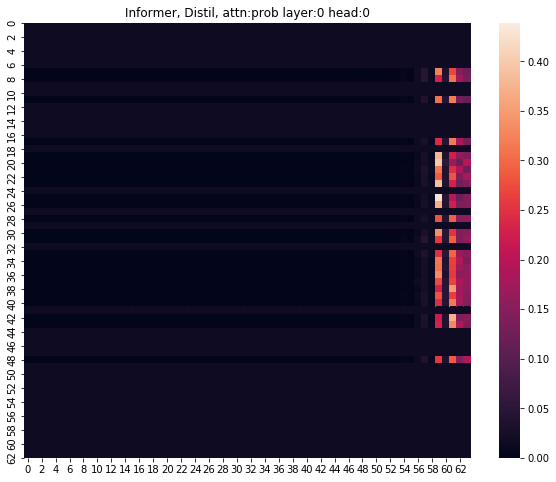

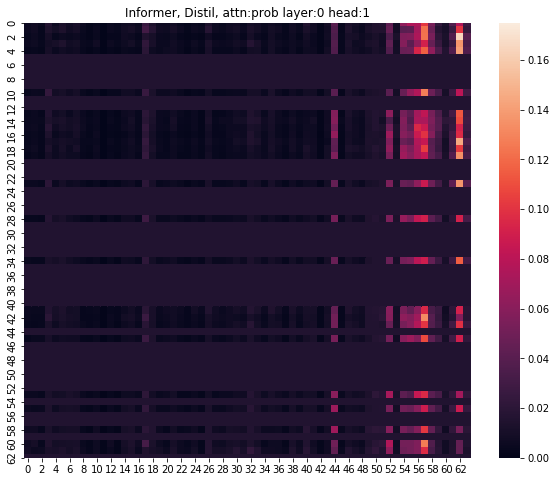

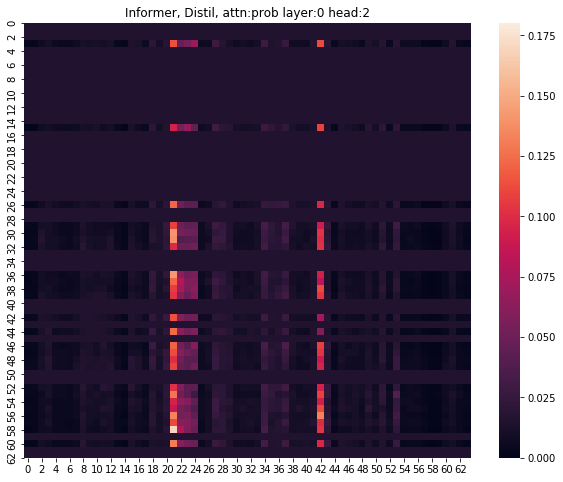

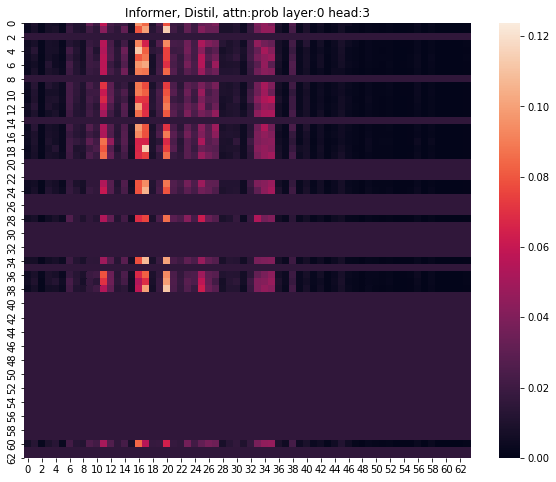

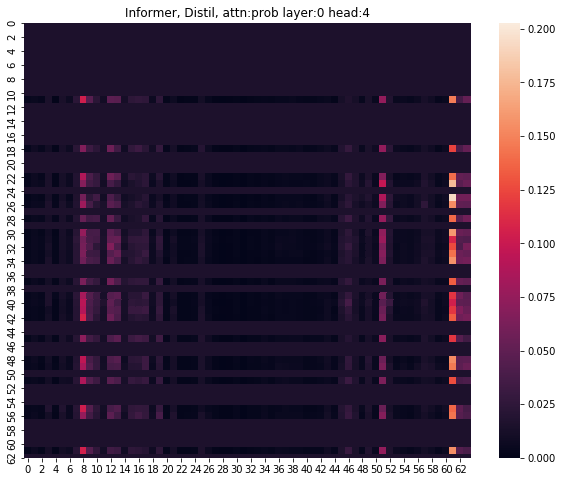

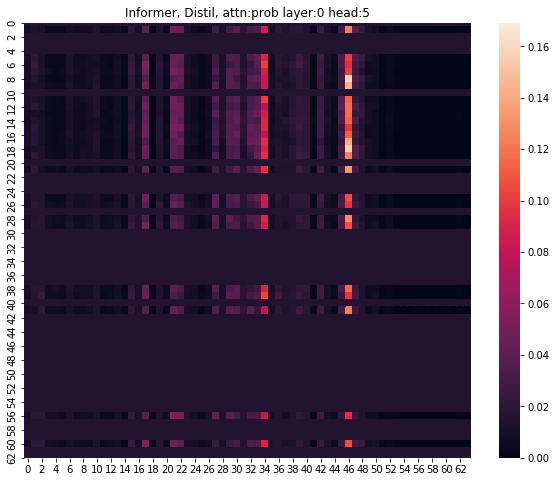

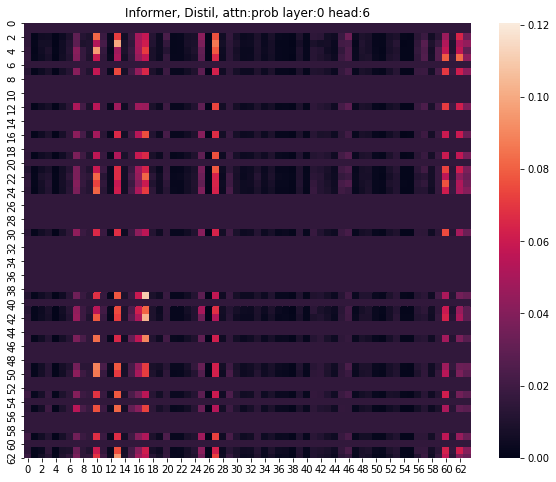

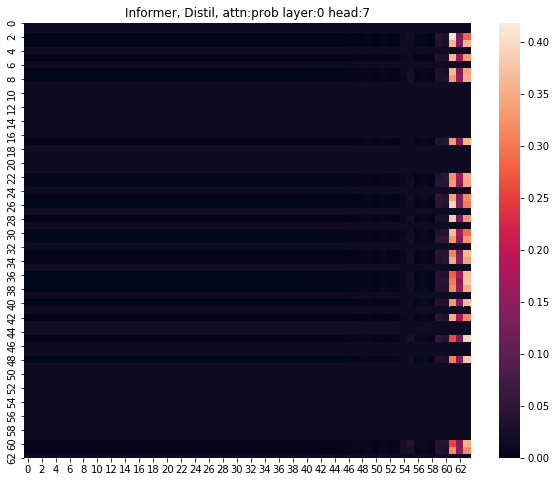



Showing attention layer 1




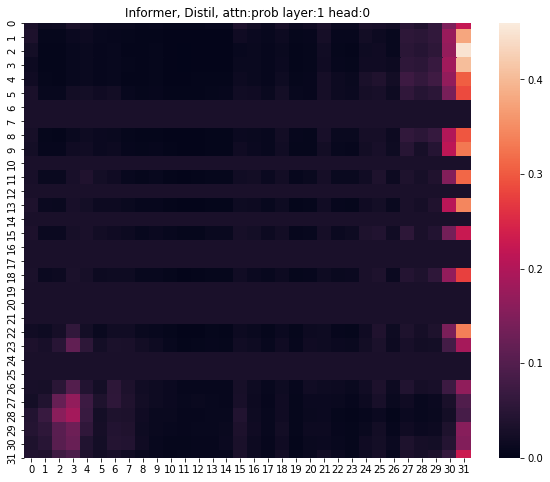

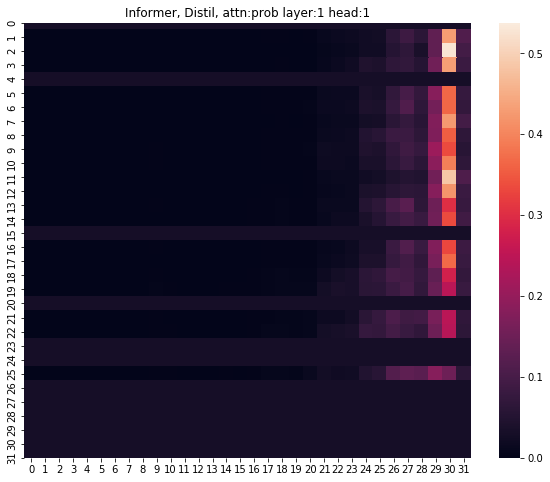

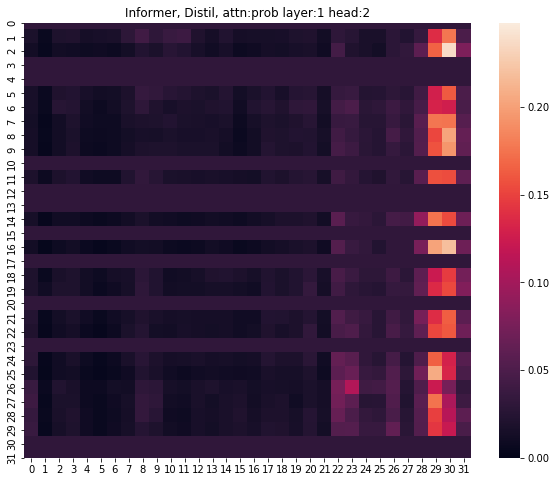

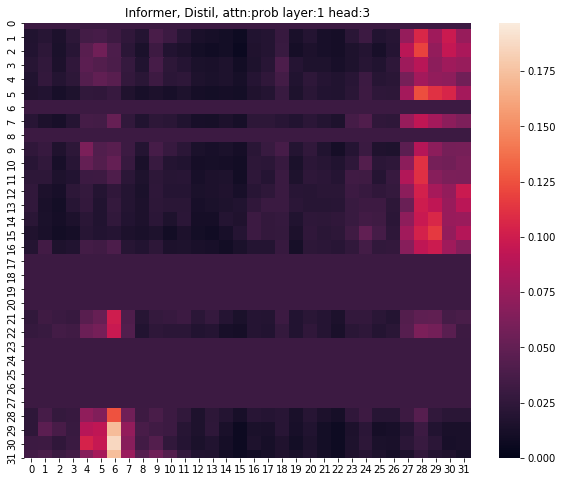

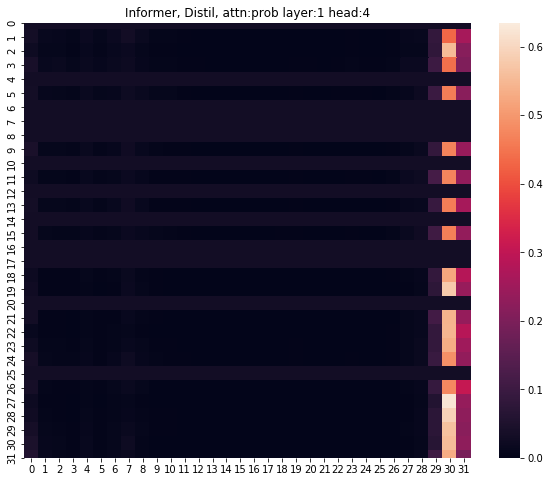

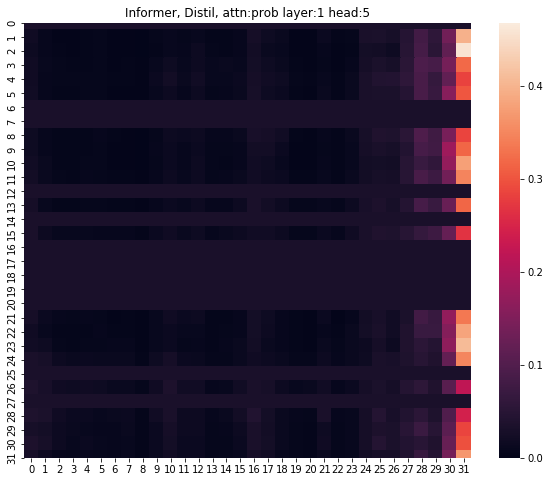

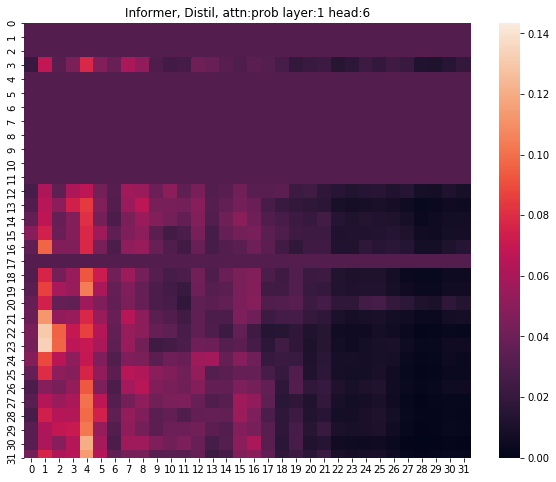

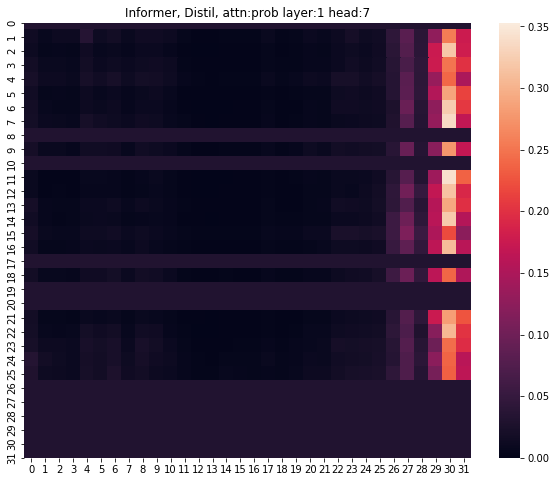

In [103]:
layers = [0,1]
distil = 'Distil' if args.distil else 'NoDistil'
for layer in layers:
    print("\n\n==========================")
    print("Showing attention layer", layer)
    print("==========================\n\n")
    for h in range(0,8):
        plt.figure(figsize=[10,8])
        plt.title('Informer, {}, attn:{} layer:{} head:{}'.format(distil, args.attn, layer, h))
        A = attn[layer][0,h].detach().cpu().numpy()
        ax = sns.heatmap(A, vmin=0, vmax=A.max()+0.01)
        plt.show()